In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from datetime import datetime
import seaborn as sns

from funciones_OD import *

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor


#from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import RobustScaler
#import keras as keras
#from keras.models import Sequential
#from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
#import tensorflow as tf


#pd.options.mode.chained_assignment = None  # default='warn' --- Para quitar los warnings de pandas y python
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # Quitar warnings tensorflow

ruta = "F:/PhD/Datos SIATA/Análisis/Descriptivo/"
archivo = "DF"
sensor = "pm25"
redondeo = 4
datos = pd.read_csv(ruta+"test_"+archivo+"_outliers_N.csv",sep=",")
entreno = pd.read_csv(ruta+"nodos_entrenamiento_sin_outliers_"+archivo+".csv",sep=",")
variables = ['pm25']#,'humedad_relativa', 'temperatura'
for sensor in variables:
    datos[sensor] = pd.Series([round(val,redondeo) for val in datos[sensor]])
    entreno[sensor] = pd.Series([round(val,redondeo) for val in entreno[sensor]])

In [2]:
nodo_entreno = [50, 134, 187, 266]
entrenamiento = pd.DataFrame()
prediccion = pd.DataFrame()
variable = sensor
parte_entreno = 0.7

inicio = datetime.now()
#now = datetime.now()
#time_rnn = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)

for en in nodo_entreno:
    datos_entreno = entreno.loc[entreno.loc[:,"codigoSerial"] == en]
    #datos_entreno = datos_entreno.iloc[:round(len(datos_entreno)*0.1),:]
    cant_entreno = round(len(datos_entreno)*parte_entreno)
    entrenamiento = pd.concat([entrenamiento,datos_entreno.iloc[:cant_entreno,:]],ignore_index=True)
    prediccion = pd.concat([prediccion,datos_entreno.iloc[cant_entreno:,:]],ignore_index=True)


entrenamiento["fechaHora"] = entrenamiento["fecha"] + " " + entrenamiento["hora"]
diferencias (entrenamiento,[variable],redondeo)

#df_small_noise = entrenamiento.loc[:,["fechaHora", variable+"_dif"]]
df_small_noise = entrenamiento.loc[:,["fechaHora", variable]]
#pd.to_datetime(df_small_noise["fechaHora"])
df_small_noise.set_index("fechaHora", inplace=True)

#df_daily_jumpsup = df_small_noise.copy() 

prediccion["fechaHora"] = prediccion["fecha"] + " " + prediccion["hora"]
prediccion_ori, prediccion, outliers = synthetic_data(prediccion,0.1,20)
diferencias (prediccion,[variable],redondeo)

#df_daily_jumpsup = prediccion.loc[:,["fechaHora", variable+"_dif"]]
df_daily_jumpsup = prediccion.loc[:,["fechaHora", variable]]
pd.to_datetime(df_daily_jumpsup["fechaHora"])
df_daily_jumpsup.set_index("fechaHora", inplace=True)



training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std

print("Number of training samples:", len(df_training_value))

TIME_STEPS = 1

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)][0])
    return np.stack(output)
    #return output


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Se incluyeron 4331 Outliers
Number of training samples: 101059
Training input shape:  (101059, 1)


In [3]:
def create_model(loss='mse'):

    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[1])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=loss)

    return model


learning_rate = 0.0001
decay_rate = 0.1
epochs = 50
momentum = 0.8
batch_size = 128

model_CV = KerasClassifier(build_fn=create_model,
                            epochs=epochs, 
                           batch_size=batch_size,  
                           verbose=0,
                           validation_split=0.1,
                           callbacks=keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"))

loss_fun = ['mse','categorical_crossentropy','binary_crossentropy']

param_grid = dict(loss=loss_fun)

grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, x_train, error_score='raise')

print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')



'''
rms = keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9, epsilon=None, decay=decay_rate)
adam = keras.optimizers.Adam(learning_rate=learning_rate)
sgd = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
optimi = [keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9, epsilon=None, decay=decay_rate),keras.optimizers.Adam(learning_rate=learning_rate),keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)]

loss_fun = ['mse','categorical_crossentropy','binary_crossentropy']


#model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False), loss='mse', metrics=['acc'])

model.summary()
#plot_model(model, to_file='model_plot_convo.png', show_shapes=True, show_layer_names=True)


# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    print(lrate)
    return lrate


# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]


exponential_decay_model_history = model.fit(
    x_train,
    x_train,
    verbose=0,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
)

fin = datetime.now()
#print("Tiempo RNN:", time_rnn.time())
#print("Tiempo de entrenamiento:",tiempo_entrenamiento)
print("Tiempo total:", fin-inicio)

plt.plot(exponential_decay_model_history.history["loss"], label="Training Loss")
plt.plot(exponential_decay_model_history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Error Loss')
plt.legend()
plt.show()
'''


C:\Users\Fernando Avila\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Fernando Avila\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Fernando Avila\anaconda3\lib\site-packages\scikeras\wrappers.py", line 1453, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\Fernando Avila\anaconda3\lib\site-packages\scikeras\wrappers.py", line 725, in fit
    self._fit(
  File "C:\Use

ValueError: Unknown label type: continuous.

To implement support, subclass KerasClassifier and override ``target_encoder`` with a transformer that supports this label type.

For information on sklearn target types, see: * https://scikit-learn.org/stable/modules/generated/sklearn.utils.multiclass.type_of_target.html * https://scikit-learn.org/stable/modules/multiclass.html

For information on the SciKeras data transformation interface, see: * https://www.adriangb.com/scikeras/stable/advanced.html#data-transformers

In [4]:
learning_rate = 0.0001
decay_rate = 0.1
epochs = 50
momentum = 0.8
batch_size = 128

def create_model():

    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[1])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )

    return model


def compile_model(model, lr = 0.001, loss='mse'):
    #model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])
    #model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=False), loss=loss, metrics=['accuracy'])
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=lr, epsilon=None), loss=loss, metrics=['accuracy'])
    return model

def fit_model(model, epochs = 50, batch_size = 128):
    history = model.fit(
        x_train,
        x_train,
        verbose = 0,
        epochs = epochs,
        batch_size = batch_size,
        validation_split=0.1,
        #callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
    )
    return history

grid_results = pd.DataFrame()

model = create_model()

for i in range (1):
    model = compile_model(model)
    history = fit_model(model)

    



'''
loss_fun = ['mse','categorical_crossentropy','binary_crossentropy']

param_grid = dict(loss=loss_fun)

grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, x_train, error_score='raise')

print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')
'''
grid_results


""


In [5]:
history.history['val_loss']


[0.0009508967050351202,
 0.0018547562649473548,
 0.00113964406773448,
 0.0023833864834159613,
 0.007073650602251291,
 0.0058431364595890045,
 0.002393062226474285,
 0.003885271493345499,
 0.008680111728608608,
 0.003161621978506446,
 0.00540505675598979,
 0.004140366800129414,
 0.002342927036806941,
 0.0031108837574720383,
 0.009121871553361416,
 0.012300961650907993,
 0.012217381037771702,
 0.020899247378110886,
 0.0258755125105381,
 0.014071965590119362,
 0.015259702689945698,
 0.013486513867974281,
 0.01738908514380455,
 0.016315186396241188,
 0.025111470371484756,
 0.033014025539159775,
 0.024373749271035194,
 0.026628926396369934,
 0.03407994657754898,
 0.035400815308094025,
 0.03174898400902748,
 0.052457332611083984,
 0.04352117329835892,
 0.034644003957509995,
 0.03526120260357857,
 0.038756199181079865,
 0.03863661363720894,
 0.044120900332927704,
 0.043572667986154556,
 0.03851914033293724,
 0.03341030329465866,
 0.04693062976002693,
 0.03354242816567421,
 0.03929990530014038

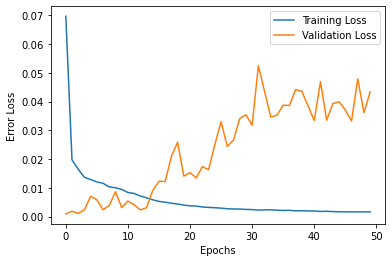

In [6]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Error Loss')
plt.legend()
plt.show()
